&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)


[Previous Notebook](Part4.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Start_Here.ipynb)
[2](Part2.ipynb)
[3](Part3.ipynb)
[4](Part4.ipynb)
[5]
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;



# Exercise  :

Now with that, you are introduced to the Problem Statement and understood the ways you need to solve it. Now is your time to Tweak, Tune and get your hands dirty with the model. 

Let us help you get started by pointing out some ways in which you can make the model more efficient. 

- Epochs: Yes, you can increase the number of epochs to train more on the dataset, but make sure you don't overfit it.
- Learning Rate: This is a very critical thing to understand and tweak as lower values make learning slow, and higher values stop the model from learning.
- Depth of the Model: We had a depth of 5 upsampling and 5 downsampling blocks, we can reduce and increase to learn complex functions.
- Dropout Rate: This would regularize the model from overfitting and learn the features across all neurons properly.
- Gatedness of the Model: You can set the parameter `gated` to `True` or `False` to see how it impacts the model.





Don't remember what an Epoch means? Worry not, head to our [Introduction to Deep Learning](../Start_Here/Intro_to_DL.ipynb) notebook to understand what an Epoch means and what the other terms mean.


Note, before you start tweaking and training your model, it would be worthwhile to refer to these to see how they affect your model: 

[Epochs impact on overfitting](https://datascience.stackexchange.com/questions/27561/can-the-number-of-epochs-influence-overfitting ) 

[Depth of the Model](https://www.quora.com/Does-adding-more-layers-always-result-in-more-accuracy-in-convolutional-neural-networks)

[Understand the Impact of Learning Rate on Neural Network Performance](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)

[Introduction to Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)

[Introduction to Optimizers](https://algorithmia.com/blog/introduction-to-optimizers)

In [1]:
# Import Necessary Libraries
from __future__ import print_function

import sys
sys.path.append('/workspace/python/source_code')

import numpy as np 
import time
import importlib
import os
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

# Custom Utlities
import model.flow_architecture as flow_architecture
import utils.data_utils as data_utils

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

2.0.0


In [2]:
batch_size = 8
dataset_size = 3000   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('data/train.tfrecords')
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)
#     training_dataset = training_dataset.repeat()

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)
#     validation_dataset = validation_dataset.repeat()

    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True)
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 343 / 32 / 3


In [3]:
def loss_image(vflow_hat, vflow):
    ''' Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    '''
    ### define the square error loss (~ 1 line of code)
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

In [4]:
def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return elu(concatenate([x, -x], axis=axis))

In [5]:
# Helper Function to Set Non-linearity
def set_nonlinearity(name):
    if name == 'concat_elu':
        return concat_elu
    elif name == 'elu':
        return tf.nn.elu
    elif name == 'concat_relu':
        return tf.nn.crelu
    elif name == 'relu':
        return tf.nn.relu
    else:
        raise('nonlinearity ' + name + ' is not supported')

In [6]:
def res_block(x, a=None, filter_size=16, nonlinearity=concat_elu, rate=0, stride=1, gated=False, name="resnet"):
    """ Residual block of 3x3 convolutions """
    # Copy of our Input
    orig_x = x
    # Get Shape of Input data
    orig_x_int_shape = flow_architecture.int_shape(x)
    
    #### First Convolution Layer
    # If Input has one channel Data ( i.e., Input is our Input Image )
    if orig_x_int_shape[3] == 1:
        x_1 = flow_architecture.conv_layer(x, 3, stride, filter_size, name + '_conv_1')
    else:
        x_1 = flow_architecture.conv_layer(nonlinearity(x), 3, stride, filter_size, name + '_conv_1')
    
    # a is fed during the Up-sampling part of the Network ( Refer Upsampling block )
    if a is not None:
        shape_a = flow_architecture.int_shape(a)
        shape_x_1 = flow_architecture.int_shape(x_1)
        paddings = [[0,0],[0, shape_x_1[1]-shape_a[1]], [0, shape_x_1[2]-shape_a[2]], [0, 0]]
        a = tf.pad(a, paddings)
        x_1 = x_1 + flow_architecture.nin(nonlinearity(a), filter_size, name + '_nin')
    # Add Activation Function and Dropout
    x_1 = nonlinearity(x_1)
    x_1 = Dropout(rate=rate)(x_1)
    
    #### Second Convolution Layer 
    # Implemented Gated Residual Blocks 
    if not gated:
        x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size, name + '_conv_2')
    else:
        x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size*2, name + '_conv_2')
        x_2_1, x_2_2 = tf.split(axis=3,num_or_size_splits=2,value=x_2)
        x_2 = x_2_1 * tf.nn.sigmoid(x_2_2)
    
    # During Down-sampling Apply Pooling layer for the Input to Match the Outout
    if int(orig_x.get_shape()[2]) > int(x_2.get_shape()[2]):
        orig_x = tf.nn.avg_pool(orig_x, [1,2,2,1], [1,2,2,1], padding='SAME')

    # Pad Input Data
    out_filter = filter_size
    in_filter = int(orig_x.get_shape()[3])
    if out_filter != in_filter:
        orig_x = tf.pad( orig_x, [[0, 0], [0, 0], [0, 0], [(out_filter-in_filter), 0]])
    # Output Input Data + Output of Convolution Layer ( Why ? Because this is a Residual Block )
    return orig_x + x_2

In [7]:
def downsampling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated,name_prefix, downsample):
    ''' An optional downsampling step followed by one (or more) residual blocks '''
    
    # Set Parameters and Call our Residual Block Function 
    if downsample:
        x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, stride=2,gated=gated, name=name_prefix + "downsample")
    for i in range(nr_res_blocks):
        x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, stride=1,rate=rate, gated=gated, name=name_prefix + str(i))      
    return x    


In [8]:
def upsumpling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, 
                        name_prefix, a):
    ''' Upsampling followed by a residual block '''
    # Set Parameters and Call our Residual Block Functions
    x = flow_architecture.transpose_conv_layer(x, 3, 2, filter_size, name_prefix)
    for i in range(nr_res_blocks):
        if i == 0:
            x = res_block(x, a, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, gated=gated, name=name_prefix + str(i))
        else:
            x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, gated=gated, name=name_prefix + str(i))

    return x

In [9]:
def conv_res(inputs, nr_res_blocks=1, rate=1.0, nonlinearity_name='concat_elu', gated=True,depth=5):
    """Builds conv part of net.
    Args:
      inputs: input images
      rate: dropout layer
    """
    # Set Non-linearity
    nonlinearity = set_nonlinearity(nonlinearity_name)
    filter_size = 8
    # Store for Concatenation of the Downsampling output with the Upsampling blocks
    a = []
    
    # First Downsampling Residual Block to Convert Input Image from ( 128  ,256 ,1 ) to ( 128 , 256 , 8)
    
    x = downsampling_res_blocks(inputs, nr_res_blocks, filter_size, nonlinearity, rate, gated, "resnet_1_", False)
    
    # Loop Through Downsampling Blocks 
    for i in range(2,1+depth):
        a.append(x)
        filter_size = 2 * filter_size
        name_prefix = "resnet" + str(i) + "_"
        x = downsampling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, name_prefix, True)

    # Loop Through Up-sampling Blocks 
    for i in range(1,depth):
        filter_size = int(filter_size /2)
        name_prefix = "up_conv_" + str(i)
        x = upsumpling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, name_prefix, a[-i])
    
    # Last Convolution Layer with Activation 
    x = flow_architecture.conv_layer(x, 3, 1, 2, "last_conv")
    x = tf.nn.tanh(x)

    return x

In [10]:
def model(boundary, rate,gated=True,depth=5):
    return conv_res(boundary, nr_res_blocks=1, rate=rate, nonlinearity_name='concat_elu', gated=gated,depth=depth)

In [11]:
# Define Dropout Rate and Set Gated = False

## TODO 
## ~~ Change parameters Here ~~
rate = 0.005
gated = True
depth = 5
lr = 0.0001
## ~~ Change parameters Here ~~

# Compile the Model
input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = model(input,rate=rate,gated=gated,depth=depth)
unet = tf.keras.Model(inputs = input, outputs=output)
unet.compile(tf.keras.optimizers.Adam(lr), loss=loss_image)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 8)  80          boundary[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Neg (TensorFlowOpLa [(None, 128, 256, 8) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 256, 16) 0           conv2d[0][0]                     
                                                                 tf_op_layer_Neg[0][0]        

In [21]:
# Let's train our Model for 20 Epochs
results = unet.fit(training_dataset, epochs=15)

Epoch 1/15
343/343 [==============================] - 10s 28ms/step - loss: 3.9042
Epoch 2/15
343/343 [==============================] - 10s 28ms/step - loss: 3.5773
Epoch 3/15
343/343 [==============================] - 10s 28ms/step - loss: 3.4731
Epoch 4/15
343/343 [==============================] - 10s 28ms/step - loss: 3.5023
Epoch 5/15
343/343 [==============================] - 10s 28ms/step - loss: 3.3777
Epoch 6/15
343/343 [==============================] - 10s 28ms/step - loss: 3.3327
Epoch 7/15
343/343 [==============================] - 10s 28ms/step - loss: 3.2789
Epoch 8/15
343/343 [==============================] - 10s 28ms/step - loss: 3.1329
Epoch 9/15
343/343 [==============================] - 10s 28ms/step - loss: 3.0561
Epoch 10/15
343/343 [==============================] - 10s 28ms/step - loss: 3.1627
Epoch 11/15
343/343 [==============================] - 10s 28ms/step - loss: 3.0170
Epoch 12/15
343/343 [==============================] - 10s 28ms/step - loss: 2.8375
E

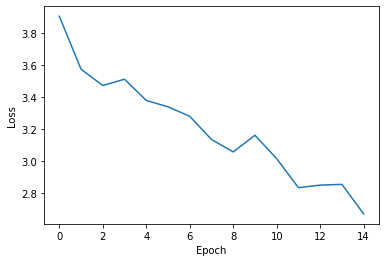

In [22]:
# Let us Plot the train History
data_utils.plot_keras_loss(results)

## Let's Test our Model

In [23]:
test_loss = unet.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 16ms/step - loss: 1.2884
The loss over the test dataset 1.288353443145752


In [24]:
## Let's Test our Model

test_loss = unet.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 15ms/step - loss: 1.2884
The loss over the test dataset 1.2883535226186116


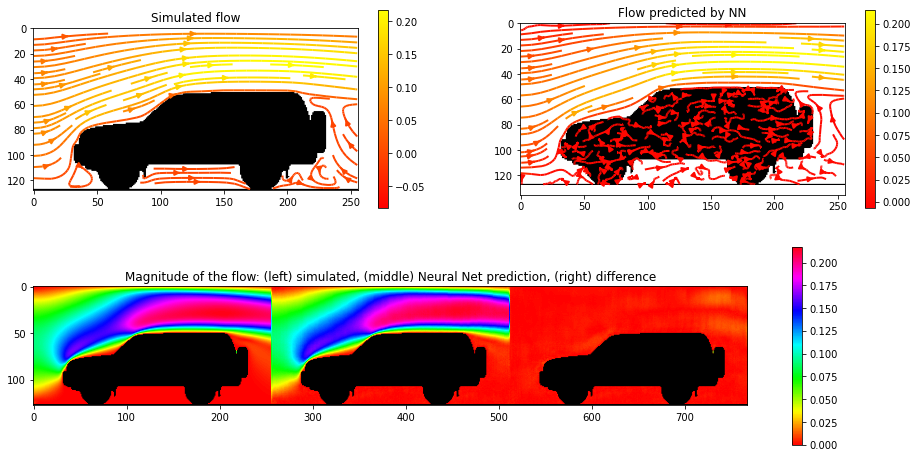

In [25]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = unet.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

## Licensing
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0)

[Previous Notebook](Part4.ipynb)
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
[1](Start_Here.ipynb)
[2](Part2.ipynb)
[3](Part3.ipynb)
[4](Part4.ipynb)
[5]
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;


&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&ensp;
[Home Page](../Start_Here.ipynb)
